# 1. Setup Environment

### 1.1. Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 1.2. Import Dataset

In [2]:
data = pd.read_csv(r'C:\Users\Work\Desktop\MS Pub\GSA\grackle_20k8p_illinois_rob_log.csv')

In [3]:
data.sample(5)
data.shape

,ID,ClutchSize,FledgeRate,FledglingSurvival,InitialAbundance,JuvenileSurvival,AdultSurvival,SYBreeding,ASYBreeding,Output
14149,14425,4.477210,0.355275,0.589385,2.803880e+06,0.550145,0.657985,0.891454,0.974632,9.942919
715,727,4.554173,0.344816,0.617570,2.814817e+06,0.575317,0.683727,0.867456,0.905035,11.465621
8423,8577,4.377170,0.358492,0.612936,2.793981e+06,0.536203,0.706876,0.869904,0.993762,12.546217
14987,15284,4.318944,0.343387,0.645207,2.827664e+06,0.551538,0.706921,0.867893,0.909699,12.135617
6054,6158,4.212432,0.350349,0.597950,2.816870e+06,0.578185,0.665341,0.882254,0.924835,9.478666


(19620, 10)

In [4]:
parameter_labels = ['ClutchSize', 'FledgeRate', 'FledglingSurvival', 'InitialAbundance', 'JuvenileSurvival', 'AdultSurvival',
                    'SYBreeding', 'ASYBreeding']

# 2. Data Preparation

In [5]:
ID = data['ID']
data.drop('ID', axis=1, inplace=True)

In [6]:
X = data.drop('Output', axis=1)
y = data['Output']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [8]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(14715, 8)

(14715,)

(4905, 8)

(4905,)

# 3. Preprocessing and Validation

### 3.1. Transformers

In [9]:
# std = StandardScaler()

### 3.2. Cross Validation

In [10]:
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

def cv_score(est, X, y, cv):
    score = np.sqrt(-cross_val_score(estimator=est, X=X, y=y, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1))
    return [score.mean(), score.std()]

# 4. Build Models

### 4.1. Algorithms

In [11]:
gbr = GradientBoostingRegressor(n_estimators=300, max_depth=3, learning_rate=0.05, subsample=0.8)
xgb = XGBRegressor(n_estimators=250, max_depth=3, learning_rate=0.05, subsample=0.8)

### 4.2. Pipelines

In [12]:
gbr_pipe = make_pipeline(gbr)
xgb_pipe = make_pipeline(xgb)

### 4.3. Scoring

In [13]:
gbr_results = cv_score(gbr_pipe, X_train, y_train, kfold)
print('GBoost RMSE: {:.4f} ({:.4f})'.format(gbr_results[0], gbr_results[1]))

GBoost RMSE: 0.1550 (0.0031)


In [14]:
xgb_results = cv_score(xgb_pipe, X_train, y_train, kfold)
print('XGBoost RMSE: {:.4f} ({:.4f})'.format(xgb_results[0], xgb_results[1]))

XGBoost RMSE: 0.1661 (0.0036)


### 4.4. Tuning

In [ ]:
grid_search = GridSearchCV(gbr,
                           param_grid={'learning_rate': [0.01, 0.05, 0.1],
                                       'n_estimators': [300, 400, 500]},
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator=gbr_pipe,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.075, 1.0, 15),
                                                        cv=10,
                                                        scoring='neg_mean_squared_error',
                                                        n_jobs=-1)

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
plt.plot(train_sizes, train_mean, color='steelblue', marker='o', markersize=5, label='Training Score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='steelblue')

plt.plot(train_sizes, test_mean, color='dimgrey', linestyle='--', marker='s', markersize=5, label='Validation Score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='dimgrey')

plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.show()

In [ ]:
learning_rate_range = [0.005, 0.01, 0.05, 0.1]

In [49]:
train_scores, test_scores = validation_curve(estimator=gbr_pipe, X=X_train, y=y_train, 
                                             param_name='gradientboostingregressor__learning_rate',
                                             param_range=learning_rate_range, cv=10,
                                             scoring='neg_mean_squared_error')

In [50]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

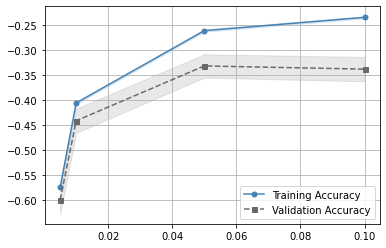

In [51]:
plt.plot(learning_rate_range, train_mean, color='steelblue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(learning_rate_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='steelblue')

plt.plot(learning_rate_range, test_mean, color='dimgrey', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(learning_rate_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='dimgrey')

plt.grid()
plt.legend(loc='lower right')
plt.show()

In [56]:
n_estimators_range = np.arange(150, 450, 50)

In [57]:
train_scores, test_scores = validation_curve(estimator=gbr_pipe, X=X_train, y=y_train, 
                                             param_name='gradientboostingregressor__n_estimators',
                                             param_range=n_estimators_range, cv=10,
                                             scoring='neg_mean_squared_error')

In [58]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

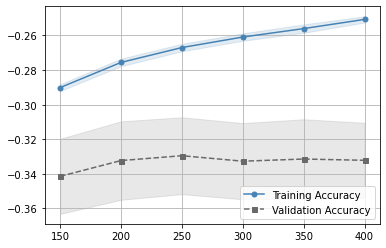

In [59]:
plt.plot(n_estimators_range, train_mean, color='steelblue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(n_estimators_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='steelblue')

plt.plot(n_estimators_range, test_mean, color='dimgrey', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(n_estimators_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='dimgrey')

plt.grid()
plt.legend(loc='lower right')
plt.show()

### 4.5. Predictions

In [15]:
gbr_pipe.fit(X_train, y_train)

Pipeline(steps=[('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=300,
                                           subsample=0.8))])

In [16]:
y_pred = gbr_pipe.predict(X_test)

### 4.6. Figures

In [17]:
featureImportance = gbr_pipe[0].fit(X_train, y_train).feature_importances_ * 100
cleanLabels = ['Clutch Size', 'Fledge Rate', 'Fledgling Survival', 'Initial Abundance', 'Juvenile Survival',
               'Adult Survival', 'Breeding Success (SY)', 'Breeding Success (ASY)']

In [18]:
importance_df = pd.DataFrame(featureImportance, columns=['Relative Influence'], index=cleanLabels)
importance_sorted = importance_df.sort_values(by='Relative Influence', axis=0, ascending=False)

In [21]:
importance_sorted

,Relative Influence
Adult Survival,61.548688
Fledgling Survival,8.626054
Juvenile Survival,8.347477
Fledge Rate,8.230254
Clutch Size,8.213224
Breeding Success (ASY),4.400107
Breeding Success (SY),0.584741
Initial Abundance,0.049456


<AxesSubplot:xlabel='Relative Influence'>

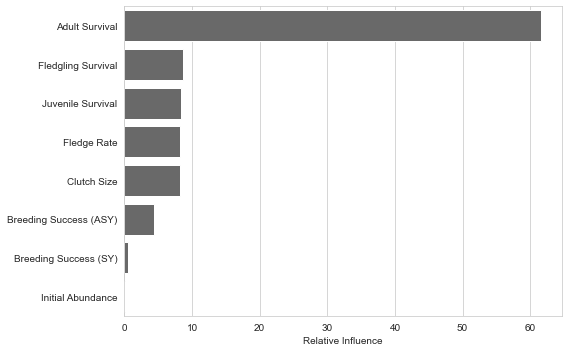

In [27]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(y=importance_sorted.index, x='Relative Influence', data=importance_sorted, color='dimgray')

fig.tight_layout()
fig.savefig(r'C:\Users\Work\Desktop\MS Pub\GSA\relative_influence_illinois.png')

<AxesSubplot:ylabel='Output'>

Text(0.5, 0, 'Predicted Output (log)')

Text(0, 0.5, 'Actual Output (log)')

(8.5, 12.5)

(8.5, 12.5)

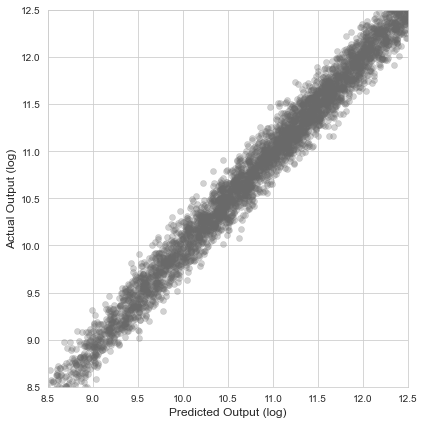

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_test, color='dimgray', edgecolor=None, alpha= 0.3)
# ax.plot([8.5, 12.5], [8.5, 12.5], c = 'red', alpha=0.7)
ax.set_xlabel('Predicted Output (log)', fontsize=12)
ax.set_ylabel('Actual Output (log)', fontsize=12)
ax.set_xlim(8.5, 12.5)
ax.set_ylim(8.5, 12.5)

fig.tight_layout()
fig.savefig(r'C:\Users\Work\Desktop\MS Pub\GSA\observed_predicted_illinois.png')